<a href="https://colab.research.google.com/github/farhanfuadabir/ASL-DataGlove/blob/main/Model__DL/Model__1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** Data



In [ ]:
!unzip -q /content/\*.zip


7 archives were successfully processed.


# **Load** Dependencies

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import librosa as lb
from joblib import load, dump
from tqdm.notebook import tqdm
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# **Constants**

In [ ]:
# Get user list
# _, filenames, _ = next(os.walk("/content/Hand-Gesture-Recognition/ContinuousDataAcquisitionPython/Data_032021"))
# users = [os.path.splitext(x)[0] for x in filenames]
# users = sorted(users, key=lambda x: (len(x), x))
users = ['001', '002', '003', '004', '005', '006', '007']
print(users)

['001', '002', '003', '004', '005', '006', '007']


In [ ]:
# Indicate segmentLength, recorditeration according to the 'serialDataAcquisition_segmented.py' script
segmentLength = 150
recorditeration = 10

# ColumnNames according to the 'serialDataAcquisition_segmented.py' script
columnName = ['timestamp', 'user_id',
              'flex_1', 'flex_2', 'flex_3', 'flex_4', 'flex_5',
              'Qw', 'Qx', 'Qy', 'Qz',
              'GYRx', 'GYRy', 'GYRz',
              'ACCx', 'ACCy', 'ACCz',
              'ACCx_body', 'ACCy_body', 'ACCz_body',
              'ACCx_world', 'ACCy_world', 'ACCz_world']

# gestures = get_gesture_names(userPath)
gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
            'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
            'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

print('Gesture List: ', gestures)
print('Number of Gestures: ', len(gestures))

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(gestures)
print("Number of Gestures Encoded: ", len(label_encoder.classes_))

Gesture List:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry', 'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']
Number of Gestures:  40
Number of Gestures Encoded:  40


# **Load** Functions

In [ ]:
# Extract user list from the Dataset

def get_user_list(userPath):
  _, filenames, _ = next(os.walk("/content/Hand-Gesture-Recognition/ContinuousDataAcquisitionPython/Data_032021"))
  users = [os.path.splitext(x)[0] for x in filenames]
  users = sorted(users, key=lambda x: (len(x), x))
  
  return users

In [ ]:
# Extract gesture names from the filenames

def get_gesture_names(userPath):
  _, _, filenames = next(os.walk(userPath))
  gestures = [os.path.splitext(x)[0] for x in filenames]
  gestures = sorted(gestures, key=lambda x: (len(x), x))

  return gestures

In [ ]:
# Extract rolling median and rolling mean filters on each channel

def apply_rolling_filters(path=''):

  # SPIKE REMOVAL FOR ALL USERS -> ROLLING MEDIAN[3]
  users = ['001', '002', '003', '004', '005', '006', '007']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
              'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(3, center=True).median()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR USER 2 ('a'-'m') -> ROLLING AVERAGE[10]
  users = ['002']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR USER 4 -> ROLLING AVERAGE[10]
  users = ['004']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
              'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR USER 6 (ASL words) -> ROLLING AVERAGE[10]
  users = ['006']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)


  # SMOOTHING FOR ALL USERS -> ROLLING AVERAGE[10]
  users = ['001', '002', '003', '004', '005', '006', '007']
  channels = ["flex_1", "flex_2", "flex_3", "flex_4", "flex_5"]

  gestures = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
              'bad', 'deaf', 'fine', 'good', 'goodbye', 'hello', 'hungry',
              'me', 'no', 'please', 'sorry', 'thankyou', 'yes', 'you']

  for user in users:
    for gesture in gestures:
      data = pd.read_csv(path + user + '/' + gesture + '.csv')
      for mode in channels:
        data[mode] = data[mode].rolling(10, center=True).mean()
        data = data.fillna(method='bfill')
        data = data.fillna(method='ffill')
      data.to_csv(path + user + '/' + gesture + '.csv', index=False)

In [ ]:
# Extract Channels From Raw Dataset

def extract_channels(columns, segmentLength, recorditeration, 
                     userPath, storePath, writeFormat='JOBLIB'):
  # Make a directory named 'Channels' in the 'storePath' if there is none already
  if not os.path.isdir(storePath):
    currentPath = os.getcwd()
    os.mkdir(currentPath + '/' + storePath)
    print("Created Folder: ", currentPath + '/' + storePath)

  if 'user_id' in columns:
    columns.remove('user_id')

  for file in gestures:
    # Make a directory after the gesture name in the 'Channels' folder, if there is none already
    if not os.path.isdir(storePath + '/' + file):
      currentPath = os.getcwd()
      os.mkdir(currentPath + '/' + storePath + '/' + file)

    source = pd.read_csv(userPath + '/' + file + '.csv')    
    
    for channel in columns:
      temp = source[channel].to_numpy()    
      arr = np.expand_dims(temp, axis=0).reshape(-1,segmentLength)
      if writeFormat.lower() == 'joblib':
        dump(arr, storePath + '/' + file + '/' + channel + '.joblib')
      elif writeFormat.lower() == 'csv':
        np.savetxt(storePath + '/' + file + '/' + channel + '.csv', arr, delimiter=",")
      else:
        raise ValueError("Invalid WriteFormat. This function can only write 'CSV' or 'JOBLIB'.")
  
  compile_channels(columns, storePath)


def compile_channels(columnName, storePath, verbose=False):
  for channel in columnName:
    df = pd.DataFrame()

    for file in gestures:
      temp = load(storePath + '/' + file + '/' + channel + '.joblib')
      temp = pd.DataFrame(temp)
      #to add label with the data
      temp = temp.assign(label=file)   
      df = df.append(temp, ignore_index=True)
    
    if verbose == True:
      print('Processing ', channel, '... Done | shape: ', df.shape)
    
    if not os.path.isdir(storePath + '/Channels'):
      currentPath = os.getcwd()
      os.mkdir(currentPath + '/' + storePath + '/Channels')
    
    dump(df['label'], storePath + '/label' + '.joblib')
    df = df.drop(['label'], axis=1).to_numpy()
    dump(df, storePath + '/Channels/' + channel + '.joblib')

In [ ]:
# Scale Channels Per User within (0, 1)

def scale_channels_per_user(users, channels, gestures, path=''):

  print(users)
  print(channels)
  print(gestures)

  max = [[] for i in range(len(users))]
  min = [[] for i in range(len(users))]

  max_gesture = [[] for i in range(len(users))]
  min_gesture = [[] for i in range(len(users))]
  for idx_user, user in enumerate(users):
    for channel in channels:
      max_array = np.zeros([recorditeration, segmentLength])
      min_array = np.full((recorditeration, segmentLength), 1000) 
      for gesture in gestures:
        data = load(path + user + '/Processed/' + gesture + '/' + channel + '.joblib')
        if np.max(data) > np.max(max_array):
          max_temp = gesture
        if np.min(data) < np.min(min_array):
          min_temp = gesture
        max_array = np.maximum(max_array, data)
        min_array = np.minimum(min_array, data)
      max[idx_user].append(np.max(max_array))
      min[idx_user].append(np.min(min_array))
      max_gesture[idx_user].append(max_temp)
      min_gesture[idx_user].append(min_temp)

  for idx_user, user in enumerate(users):
    for idx_channel, channel in enumerate(channels):
      for gesture in gestures:
        data = load(path + user + '/Processed/' + gesture + '/' + channel + '.joblib')
        data = (data - min[idx_user][idx_channel]) / (max[idx_user][idx_channel] - min[idx_user][idx_channel])
        dump(data, path + user + '/Processed/' + gesture + '/' + channel + '.joblib')

  print("max array: ", max)
  print("max at gestures: ", max_gesture)
  print("max array length: ", len(max))
  print("min array: ", min)
  print("min at gestures: ", min_gesture)
  print("min array length: ", len(min))

# **Load** Feature Extraction Functions

In [ ]:
# def correlation(x):
#   cor = []
#   for n in range(x.shape[0]):
#     cor.append(np.correlate(x[n, :], x[n, :])[0])
#   return np.array(cor)
# #

# def mean_crossing_rate(x):
#   mcr = []
#   for n in range(x.shape[0]):
#     mcr.append(lb.feature.zero_crossing_rate(x[n, :] - np.mean(x[n, :]))[0, 0])
#   return np.array(mcr)


# def get_entropy(x, axis = 1):
#   x = x / np.sum(x, axis = axis, keepdims=True)
#   entropy = np.sum(sp.special.entr(x), axis = axis)
#   return entropy


# def number_of_peaks(x):
#   npk = []
#   for n in range(x.shape[0]):
#     thres = (np.max(x[n, :]) / 3)
#     peaks, _ = sp.signal.find_peaks(x[n, :], thres)
#     npk.append(len(peaks))
#   return np.array(npk, dtype=float)


# def get_stat_features(x, axis=1, prefix=''):

#   # print('Calculating Features...', end = " ")
#   min = np.min(x, axis = axis)
#   max = np.max(x, axis = axis)
#   std = np.std(x, axis = axis)
#   avg = np.mean(x, axis = axis)
#   var = np.var(x, axis = axis)
#   ptp = np.ptp(x, axis = axis)
#   mrc = np.max(np.diff(x, axis = axis), axis = axis)
#   arc = np.mean(np.diff(x, axis = axis), axis = axis)
#   src = np.std(np.diff(x, axis = axis), axis = axis)
#   mad = sp.stats.median_absolute_deviation(x, axis = axis)
#   iqr = sp.stats.iqr(x, axis = axis)
#   cor = correlation(x)
#   mcr = mean_crossing_rate(x)
#   rms = np.sum(np.square(x), axis = axis)
#   # print('Done!')
  
#   feature_names = ['min', 'max', 'std', 'avg', 'var', 
#                    'ptp', 'mrc', 'arc', 'src', 'mad', 
#                    'iqr', 'cor', 'mcr', 'rms']
#   columnName = [prefix + '_' + sub for sub in feature_names]

#   stat_features = pd.DataFrame(np.stack((min, max, std, avg, 
#                                          var, ptp, mrc, arc, 
#                                          src, mad, iqr, cor, 
#                                          mcr, rms), axis=1), columns=columnName)

#   return stat_features
 

# def get_freq_features(x, axis=1, fs=100, nperseg=150, prefix=''):

#   # print('Calculating Features...', end = " ")
#   freq, psd = sp.signal.welch(x, fs, nperseg = nperseg, axis = axis)
#   mpw = np.max(psd, axis = axis)
#   ent = get_entropy(psd, axis = axis)
#   ctf = np.divide(np.sum((freq * psd), axis = axis), np.sum(psd, axis = axis))
#   mxf = np.argmax(psd, axis = axis)
#   enr = np.sum(np.square(psd), axis = axis) / nperseg
#   skw = sp.stats.skew(x, axis = axis)
#   kut = sp.stats.kurtosis(x, axis = axis)
#   npk = number_of_peaks(psd)
#   # print('Done!')

#   feature_names = ['mpw', 'ent', 'ctf', 'mxf', 'enr', 'skw', 'kut', 'npk']
#   columnName = [prefix + '_' + sub for sub in feature_names]

#   freq_features = pd.DataFrame(np.stack((mpw, ent, ctf, mxf, enr, skw, 
#                                          kut, npk), axis=1), columns=columnName)

#   return freq_features


# def get_mutual_features(x, y, z, axis=1, nperseg=150, prefix=''):
#   cxy = []
#   cxz = []
#   cyz = []
#   vxy = []
#   vxz = []
#   vyz = []
#   # print('Calculating Features...', end = " ")
#   for n in range(x.shape[0]):
#     cxy.append(np.corrcoef(x[n, :].ravel(), y[n, :].ravel())[0, 1])
#     cxz.append(np.corrcoef(x[n, :].ravel(), z[n, :].ravel())[0, 1])
#     cyz.append(np.corrcoef(y[n, :].ravel(), z[n, :].ravel())[0, 1])
#     vxy.append(np.cov(x[n, :].ravel(), y[n, :].ravel())[0, 1])
#     vxz.append(np.cov(x[n, :].ravel(), z[n, :].ravel())[0, 1])
#     vyz.append(np.cov(y[n, :].ravel(), z[n, :].ravel())[0, 1])
#   cxy = np.array(cxy)
#   cxz = np.array(cxz)
#   cyz = np.array(cyz)
#   vxy = np.array(vxy)
#   vxz = np.array(vxz)
#   vyz = np.array(vyz)
#   sma = (np.trapz(x, axis = axis) + np.trapz(x, axis = axis) + np.trapz(x, axis = axis)) / nperseg
#   # print('Done!')

#   feature_names = ['cxy', 'cxz', 'cyz', 'vxy', 'vxz', 'vyz', 'sma']
#   columnName = [prefix + '_' + sub for sub in feature_names]

#   mutual_features = pd.DataFrame(np.stack((cxy, cxz, cyz, vxy, vxz, vyz, sma), 
#                                         axis=1), columns=columnName)

#   return mutual_features


# def get_velocity(x, axis = 1, nperseg = 150):
#   return np.trapz(x, axis = axis) / nperseg


# def get_fft_coefs(x, fs = 100, n = 20, axis = 1):
#   # print('Calculating Features...', end = " ")
#   _, psd = sp.signal.welch(x, fs, nperseg = n, axis = axis)
#   # print('Done!')
#   return psd

In [ ]:
# def extract_features(storePath):

#   FLEX1 = load(storePath + '/Channels/flex_1.joblib')
#   FLEX2 = load(storePath + '/Channels/flex_2.joblib')
#   FLEX3 = load(storePath + '/Channels/flex_3.joblib')
#   FLEX4 = load(storePath + '/Channels/flex_4.joblib')
#   FLEX5 = load(storePath + '/Channels/flex_5.joblib')

#   ACCx = load(storePath + '/Channels/ACCx_world.joblib')
#   ACCy = load(storePath + '/Channels/ACCy_world.joblib')
#   ACCz = load(storePath + '/Channels/ACCz_world.joblib')

#   ACCm = np.sqrt(ACCx**2 + ACCy**2 + ACCz**2)
#   dump(ACCm, storePath + '/Channels/ACCm_world.joblib')

#   GYRx = load(storePath + '/Channels/GYRx.joblib')
#   GYRy = load(storePath + '/Channels/GYRy.joblib')
#   GYRz = load(storePath + '/Channels/GYRz.joblib')

#   GYRm = np.sqrt(GYRx**2 + GYRy**2 + GYRz**2)
#   dump(GYRm, storePath + '/Channels/GYRm.joblib')

#   stat_ACCx = get_stat_features(ACCx, axis=1, prefix="ACCx")
#   stat_ACCy = get_stat_features(ACCy, prefix="ACCy")
#   stat_ACCz = get_stat_features(ACCz, prefix="ACCz")
#   stat_ACCm = get_stat_features(ACCm, prefix="ACCm")
#   stat_GYRx = get_stat_features(GYRx, prefix="GYRx")
#   stat_GYRy = get_stat_features(GYRy, prefix="GYRy")
#   stat_GYRz = get_stat_features(GYRz, prefix="GYRz")
#   stat_GYRm = get_stat_features(GYRm, prefix="GYRm")
#   stat_FLEX1 = get_stat_features(FLEX1, prefix="FLEX1")
#   stat_FLEX2 = get_stat_features(FLEX2, prefix="FLEX2")
#   stat_FLEX3 = get_stat_features(FLEX3, prefix="FLEX3")
#   stat_FLEX4 = get_stat_features(FLEX4, prefix="FLEX4")
#   stat_FLEX5 = get_stat_features(FLEX5, prefix="FLEX5")

#   freq_ACCx = get_freq_features(ACCx, prefix="ACCx")
#   freq_ACCy = get_freq_features(ACCy, prefix="ACCy")
#   freq_ACCz = get_freq_features(ACCz, prefix="ACCz")
#   freq_ACCm = get_freq_features(ACCm, prefix="ACCm")
#   freq_GYRx = get_freq_features(GYRx, prefix="GYRx")
#   freq_GYRy = get_freq_features(GYRy, prefix="GYRy")
#   freq_GYRz = get_freq_features(GYRz, prefix="GYRz")
#   freq_GYRm = get_freq_features(GYRm, prefix="GYRm")
#   freq_FLEX1 = get_freq_features(FLEX1, prefix="FLEX1")
#   freq_FLEX2 = get_freq_features(FLEX2, prefix="FLEX2")
#   freq_FLEX3 = get_freq_features(FLEX3, prefix="FLEX3")
#   freq_FLEX4 = get_freq_features(FLEX4, prefix="FLEX4")
#   freq_FLEX5 = get_freq_features(FLEX5, prefix="FLEX5")

#   mutual_ACC = get_mutual_features(ACCx, ACCy, ACCz, prefix='ACC')
#   mutual_GYR = get_mutual_features(GYRx, GYRy, GYRz, prefix='GYR')

#   X = pd.concat([stat_ACCx, stat_ACCy, stat_ACCz, stat_ACCm, 
#                 stat_GYRx, stat_GYRy, stat_GYRz, stat_GYRm,
#                 stat_FLEX1, stat_FLEX2, stat_FLEX3, stat_FLEX4, stat_FLEX5,
#                 freq_ACCx, freq_ACCy, freq_ACCz, freq_ACCm,
#                 freq_GYRx, freq_GYRy, freq_GYRz, freq_GYRm,
#                 freq_FLEX1, freq_FLEX2, freq_FLEX3, freq_FLEX4, freq_FLEX5,
#                 mutual_ACC, mutual_GYR], axis=1)

#   return X


# **Preprocess** and **Extract** Channels 

In [ ]:
# Apply Rolling Filters
print("Applying Rolling Filters...", end='')
apply_rolling_filters()
print("Done\n\n")


# Extract Channels
print("Extracting Channels...\n")

for user in tqdm(users):
  userPath = user
  storePath = userPath + '/' + 'Processed'
  extract_channels(columnName, segmentLength, recorditeration, 
                   userPath=userPath, storePath=storePath, writeFormat='joblib')
print("Done\n\n")


# # Scale Channels
# print("Applying Scaling...", end='')
# scale_channels_per_user(users=users, channels=['flex_1', 'flex_2', 'flex_3', 
#                                          'flex_4', 'flex_5'], gestures=gestures)
# print("Done\n\n")


Applying Rolling Filters...Done


Extracting Channels...



Created Folder:  /content/001/Processed
Created Folder:  /content/002/Processed
Created Folder:  /content/003/Processed
Created Folder:  /content/004/Processed
Created Folder:  /content/005/Processed
Created Folder:  /content/006/Processed
Created Folder:  /content/007/Processed

Done




In [ ]:
 
# load a list of files and return as a 3d numpy array
def stack_channels(filenames, path):
	loaded = list()
	for name in filenames:
		data = load(path + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(path):
  channel_path = 'Channels/'
  # load all 3 files as a single array
  filenames = ['ACCx_world.joblib', 'ACCy_world.joblib', 'ACCz_world.joblib', 'GYRx.joblib', 'GYRy.joblib', 'GYRz.joblib', 'flex_1.joblib', 'flex_2.joblib', 'flex_3.joblib', 'flex_4.joblib', 'flex_5.joblib']
  # load input data
  X = stack_channels(filenames, path + channel_path)
  # load class output
  y = load(path + 'label.joblib').to_numpy()
  # one-hot-encode labels
  y = to_categorical(label_encoder.transform(y))
  return X, y
 
# load the dataset, returns train and test X and y elements
# def load_dataset(path):
#   # load all train
#   trainX, trainy = load_dataset_group('train', path)
#   print('trainX shape: ', trainX.shape, '   |   trainy shape: ', trainy.shape)
#   # load all test
#   testX, testy = load_dataset_group('test', path)
#   print('testX shape: ', testX.shape, '   |   testy shape: ', testy.shape)
#   # zero-offset class values
#   trainy = trainy - 1
#   testy = testy - 1
#   # one hot encode y
#   trainy = to_categorical(trainy)
#   testy = to_categorical(testy)
#   print('Final Dataset shape: \n\nTrain Set: ', end='')
#   print(trainX.shape, '<----->', trainy.shape, '\nTest Set: ', testX.shape, '<----->', testy.shape)
#   return trainX, trainy, testX, testy



# load data
user = '001'
dataset_path = '/content/' + user + '/Processed/'
X, y = load_dataset(dataset_path)

print(X.shape)
print(y.shape)

(400, 150, 11)
(400, 40)


In [ ]:
# Extract Features
print("Extracting Channels and Labels...\n")
channel_sets = []
label_sets = []

for user in tqdm(users):
  channel_path = '/content/' + user + '/Processed/'
  X_temp, y_temp = load_dataset(channel_path)
  channel_sets.append(X_temp)
  label_sets.append(y_temp)
print("Done")

Extracting Channels and Labels...




Done


In [ ]:
print(len(channel_sets))
print(type(channel_sets[0]))
print(channel_sets[0].shape)

7
<class 'numpy.ndarray'>
(400, 150, 11)


In [ ]:
# test_users = ['002', '004', '007']
test_users = ['002', '004', '007']
train_users = [x for x in users if x not in test_users]

print("Train Set User ID: ", train_users)
print("Test Set User ID: ", test_users)

Train Set User ID:  ['001', '003', '005', '006']
Test Set User ID:  ['002', '004', '007']


In [ ]:

print(X_train.shape)

print(label_sets[0].shape)

(2000, 150, 11)
(400, 40)


In [ ]:
print("Compiling Train Set... ")

X_train = np.zeros(channel_sets[0].shape)
y_train = np.zeros(label_sets[0].shape)

for user in tqdm(train_users):
  X_train = np.append(X_train, channel_sets[int(user)-1], axis=0)
  y_train = np.append(y_train, label_sets[int(user)-1], axis=0)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)


print("\n\nCompiling Train Set... ")

X_test = np.zeros(channel_sets[0].shape)
y_test = np.zeros(label_sets[0].shape)

for user in tqdm(test_users):
  X_test = np.append(X_test, channel_sets[int(user)-1], axis=0)
  y_test = np.append(y_test, label_sets[int(user)-1], axis=0)

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Compiling Train Set... 



X_train shape:  (2000, 150, 11)
y_train shape:  (2000, 40)


Compiling Train Set... 



X_test shape:  (1600, 150, 11)
y_test shape:  (1600, 40)


# **CNN** Model

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, verbose, epochs, batch_size):
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  # model.compile(loss='categorical_crossentropy', optimizer='adam', 
  #               metrics='categorical_accuracy')
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=['categorical_accuracy', f1_m, precision_m, recall_m])
  print(model.summary())
  print('\n\n')
  # fit network
  # model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # # evaluate model
  # _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  import time
  t_start = time.clock()
  from keras import callbacks 
  # earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", 
  #                                         patience = 10, verbose = 1, 
  #                                         restore_best_weights = True) 

  # history = model.fit(trainX, trainy, batch_size = batch_size,  
  #                     epochs = epochs, validation_data =(testX, testy),  
  #                     callbacks =[earlystopping]) 
  history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

  t_end = time.clock()

  print('\n-------------------\n')

  #_, accuracy_train = model.evaluate(X_train, y_train)
  loss_train, accuracy_train, f1_score_train, precision_train, recall_train = model.evaluate(trainX, trainy, verbose=1)
  print('Train Accuracy: %.2f' % (accuracy_train*100))
  print('Train F1 Score: %.2f' % (f1_score_train*100))
  print('Train Time: ', t_end - t_start)

  t_start = time.clock()
  #_, accuracy_test = model.evaluate(X_test, y_test)
  loss_test, accuracy_test, f1_score_test, precision_test, recall_test = model.evaluate(testX, testy, verbose=1)
  print('Test Accuracy: %.2f' % (accuracy_test*100))
  print('Test F1 Score: %.2f' % (f1_score_test*100))
  t_end = time.clock()
  print('Test Time: ', t_end - t_start)

  return f1_score_test, history
 
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10, verbose=False, epochs=10, batch_size=32):
  # repeat experiment
  scores = list()
  for r in tqdm(range(repeats)):
    score, history = evaluate_model(trainX, trainy, testX, testy, verbose, epochs, batch_size)
    print('Score:', '%.3f' % (score * 100.0))
    scores.append(score)
  # summarize results
  summarize_results(scores)

# **Train**

In [ ]:
# for single iteration
score, history = evaluate_model(X_train, y_train, X_test, y_test, verbose=True, epochs=150, batch_size=16)
print('Score:', '%.3f' % (score * 100.0))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 148, 64)           2176      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 146, 64)           12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 146, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4672)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               467300    
_________________________________________________________________
dense_7 (Dense)              (None, 40)               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


125/125 [==============================] - 2s 14ms/step - loss: 13.0379 - categorical_accuracy: 0.1706 - f1_m: 0.1919 - precision_m: 0.3672 - recall_m: 0.1370
Epoch 2/150
125/125 [==============================] - 2s 14ms/step - loss: 1.6117 - categorical_accuracy: 0.3759 - f1_m: 0.4274 - precision_m: 0.5656 - recall_m: 0.3581
Epoch 3/150
125/125 [==============================] - 2s 14ms/step - loss: 1.9181 - categorical_accuracy: 0.4184 - f1_m: 0.4453 - precision_m: 0.4825 - recall_m: 0.4250
Epoch 4/150
125/125 [==============================] - 2s 14ms/step - loss: 5.0939 - categorical_accuracy: 0.4034 - f1_m: 0.4072 - precision_m: 0.4409 - recall_m: 0.3899
Epoch 5/150
125/125 [==============================] - 2s 14ms/step - loss: 1.5644 - categorical_accuracy: 0.3860 - f1_m: 0.4006 - precision_m: 0.4473 - recall_m: 0.3767
Epoch 6/150
125/125 [==============================] - 2s 14ms/step - loss: 4.8120 - categorical_accuracy: 0.4585 - f1_m: 0.4889 - precision_m: 0.5158 - recall_m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


63/63 [==============================] - 1s 7ms/step - loss: 8230.8047 - categorical_accuracy: 0.0475 - f1_m: 0.0429 - precision_m: 0.1399 - recall_m: 0.0273
Train Accuracy: 4.75
Train F1 Score: 4.29
Train Time:  453.54650100000003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


50/50 [==============================] - 1s 6ms/step - loss: 4542448.5000 - categorical_accuracy: 0.0350 - f1_m: 0.0294 - precision_m: 0.0598 - recall_m: 0.0225
Test Accuracy: 3.50
Test F1 Score: 2.94
Test Time:  0.787717000000157
Score: 2.942


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


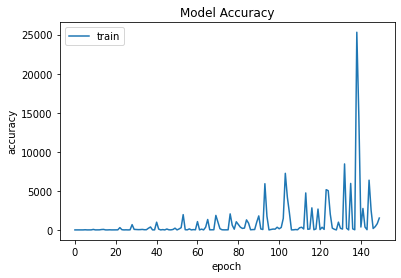

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Extract** Features and Labels

In [ ]:
# Extract Features
print("Extracting Features and Labels...\n")
feature_sets = []
label_sets = []

for user in tqdm(users):
  userPath = user
  storePath = userPath + '/' + 'Processed'
  X_temp = extract_features(storePath)
  y_temp = load(storePath + '/label.joblib')
  y_temp = y_temp.to_numpy().ravel()
  y_temp = label_encoder.transform(y_temp)
  feature_sets.append(X_temp)
  label_sets.append(y_temp)
print("Done")

Extracting Features and Labels...




Done


In [ ]:
print(len(gestures))

40


# **Set** Train and Test Sets

In [ ]:
test_users = ['002', '004', '007']
# test_users = ['001', '003', '005']
train_users = [x for x in users if x not in test_users]

print("Train Set User ID: ", train_users)
print("Test Set User ID: ", test_users)

Train Set User ID:  ['001', '003', '005', '006']
Test Set User ID:  ['002', '004', '007']


## **Compile** Train and Test Sets

In [ ]:
print("Compiling Train Set... ")

X_train = pd.DataFrame()
y_train = np.array([])

for user in tqdm(train_users):
  X_train = X_train.append(feature_sets[int(user)-1], ignore_index=True)
  y_train = np.append(y_train, label_sets[int(user)-1])

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)


print("\n\nCompiling Train Set... ")

X_test = pd.DataFrame()
y_test = np.array([])

for user in tqdm(test_users):
  X_test = X_test.append(feature_sets[int(user)-1], ignore_index=True)
  y_test = np.append(y_test, label_sets[int(user)-1])

print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

accuracy = 0
num_iter = 10
failed_classes = set()
for i in range(num_iter):
  pipe = Pipeline([('nomalizer', StandardScaler()), ('clf', RandomForestClassifier(n_estimators=100))])
  # clf = RandomForestClassifier(n_estimators=100)
  pipe.fit(X_train,y_train)
  y_pred = pipe.predict(X_test)
  accuracy += accuracy_score(y_test,y_pred)
  failed_classes = failed_classes.union(set(y_test.astype(int)) - set(y_pred.astype(int)))
accuracy /= num_iter

# accuracy = 0
# num_iter = 10
# failed_classes = set()
# for i in range(num_iter):
#   clf = RandomForestClassifier(n_estimators=100)
#   # clf = SVC()
#   clf.fit(X_train,y_train)
#   y_pred = clf.predict(X_test)
#   accuracy += accuracy_score(y_test,y_pred)
#   failed_classes = failed_classes.union(set(y_test.astype(int)) - set(y_pred.astype(int)))
# accuracy /= num_iter

failed_classes = label_encoder.inverse_transform(list(failed_classes))

print("\nAccuracy Score: %0.2f" %(accuracy_score(y_test,y_pred)))
print("Failed Classes: ", failed_classes)

Compiling Train Set... 



X_train shape:  (1600, 300)
y_train shape:  (1600,)


Compiling Train Set... 



X_test shape:  (1200, 300)
y_test shape:  (1200,)

Accuracy Score: 0.73
Failed Classes:  []


# **Classify**

In [ ]:
#@title #**Classifier**

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import shuffle


dict_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000,solver='saga'),
    "Nearest Neighbors": KNeighborsClassifier(),
    "RBF SVM": SVC(C=10000,gamma=0.1),
    "Linear SVM": SVC(kernel='linear'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Gaussian Process": GaussianProcessClassifier()
}

#@markdown ###Select classifier
classifier = "Random Forest" #@param ["Logistic Regression", "Nearest Neighbors", "RBF SVM", "Linear SVM", "Gradient Boosting Classifier", "Decision Tree", "Random Forest", "Neural Net", "Naive Bayes", "AdaBoost", "QDA", "Gaussian Process"]
clf = dict_classifiers[classifier]

X_train, y_train = shuffle(X_train, y_train, random_state=1234)

clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Test Accuracy: %0.2f" %(accuracy_score(y_test,y_pred)))
if len(set(y_test)) > len(set(y_pred)):
  print("The model did not predict the following classes at all...")
  print(label_encoder.inverse_transform(list(set(y_test.astype(int)) - set(y_pred.astype(int)))))

print("\n\n")

show_classification_report = False #@param {type:"boolean"}
if show_classification_report:
  print(classification_report(y_test, y_pred))


show_confusion_matrix = False #@param {type:"boolean"}
if show_confusion_matrix:
  fig, ax = plt.subplots(figsize=(15, 15))
  title = "Confusion Matrix"
  ax.set_title(title)
  ax.set_facecolor('xkcd:white')

  # Plot Confusion Matrix
  plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_))
  # plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_),
  #                             cmap=plt.cm.Blues,
  #                             normalize=None)

  plt.xticks(rotation=90)
  plt.show()

#@markdown ---

Test Accuracy: 0.64
The model did not predict the following classes at all...
['a' 'v' 'x' 'e' 'm' 'n' 's' 't']





# **Train** Batch Classifier

In [ ]:

import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier


dict_classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000,solver='saga'),
    "Nearest Neighbors": KNeighborsClassifier(),
    "RBF SVM": SVC(C=10000,gamma=0.1),
    "Linear SVM": SVC(kernel='linear'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=1000),
    "Decision Tree": tree.DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Gaussian Process": GaussianProcessClassifier()
}

dict_normalizers = {
    'StandardScaler': "StandardScaler",
    'MinMaxScaler':"MinMaxScaler",
    'MaxAbsScaler':"MaxAbsScaler",
    'RobustScaler':"RobustScaler",
    'QuantileTransformer-Normal':"QuantileTransformer(output_distribution='normal')",
    'QuantileTransformer-Uniform':"QuantileTransformer(output_distribution='uniform')",
    'PowerTransformer-Yeo-Johnson':"PowerTransformer(method='yeo-johnson')",
    'Normalizer':"Normalizer"
}


def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
    is because it is very easy to save the whole dictionary with the pickle module.

    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train.
    So it is best to train them on a smaller dataset first and
    decide whether you want to comment them out or not based on the test accuracy score.
    """

    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.time()
        classifier.fit(X_train, Y_train)
        t_end = time.time()

        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)

        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models



def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]

    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]

    display(df_.sort_values(by=sort_by, ascending=False))


# Train-Test Split
# X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state=1234)

dict_models = batch_classify(X_train, y_train, X_test, y_test, no_classifiers = 10)
display_dict_models(dict_models)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


trained Logistic Regression in 111.51 s
trained Nearest Neighbors in 0.05 s
trained RBF SVM in 2.41 s
trained Linear SVM in 29.96 s
trained Gradient Boosting Classifier in 327.13 s
trained Decision Tree in 0.50 s
trained Random Forest in 24.52 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


trained Neural Net in 15.50 s
trained Naive Bayes in 0.01 s
trained AdaBoost in 3.96 s


,classifier,train_score,test_score,train_time
6,Random Forest,1.000000,0.736667,24.519986
5,Decision Tree,1.000000,0.597500,0.503465
8,Naive Bayes,0.871875,0.562500,0.012109
4,Gradient Boosting Classifier,1.000000,0.519167,327.129731
3,Linear SVM,0.977500,0.385000,29.956239
7,Neural Net,0.947500,0.341667,15.503918
0,Logistic Regression,0.643125,0.310000,111.513594
1,Nearest Neighbors,0.965625,0.288333,0.052150
9,AdaBoost,0.200625,0.182500,3.957951
2,RBF SVM,1.000000,0.025000,2.405984


In [ ]:
print("Compiling Train Set... ")

X = pd.DataFrame()
y = np.array([])

for user in tqdm(users):
  X = X.append(feature_sets[int(user)-1], ignore_index=True)
  y = np.append(y, label_sets[int(user)-1])

print("X shape: ", X.shape)
print("y shape: ", y.shape)

# Train-Test Split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.50, random_state=1234)

clf = RandomForestClassifier(n_estimators=100)

# X, y = shuffle(X, y, random_state=42)

clf.fit(X_tr,y_tr)
y_pred = clf.predict(X_test)

print("Test Accuracy: %0.2f" %(accuracy_score(y_test,y_pred)))
if len(set(y_test)) > len(set(y_pred)):
  print("The model did not predict the following classes at all...")
  print(label_encoder.inverse_transform(list(set(y_test.astype(int)) - set(y_pred.astype(int)))))

print("\n\n")

print(classification_report(y_test, y_pred))

Compiling Train Set... 



X shape:  (2800, 300)
y shape:  (2800,)
Test Accuracy: 0.98



              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        30
         1.0       1.00      1.00      1.00        42
         2.0       1.00      1.00      1.00        34
         3.0       0.89      0.92      0.90        36
         4.0       0.97      0.97      0.97        37
         5.0       1.00      1.00      1.00        41
         6.0       1.00      1.00      1.00        31
         7.0       1.00      1.00      1.00        30
         8.0       1.00      1.00      1.00        37
         9.0       1.00      1.00      1.00        37
        10.0       1.00      0.94      0.97        34
        11.0       0.97      1.00      0.98        30
        12.0       1.00      1.00      1.00        38
        13.0       1.00      1.00      1.00        41
        14.0       1.00      1.00      1.00        39
        15.0       1.00      1.00      1.00        32
        16.0     

## **Plot** Confusion Matrix

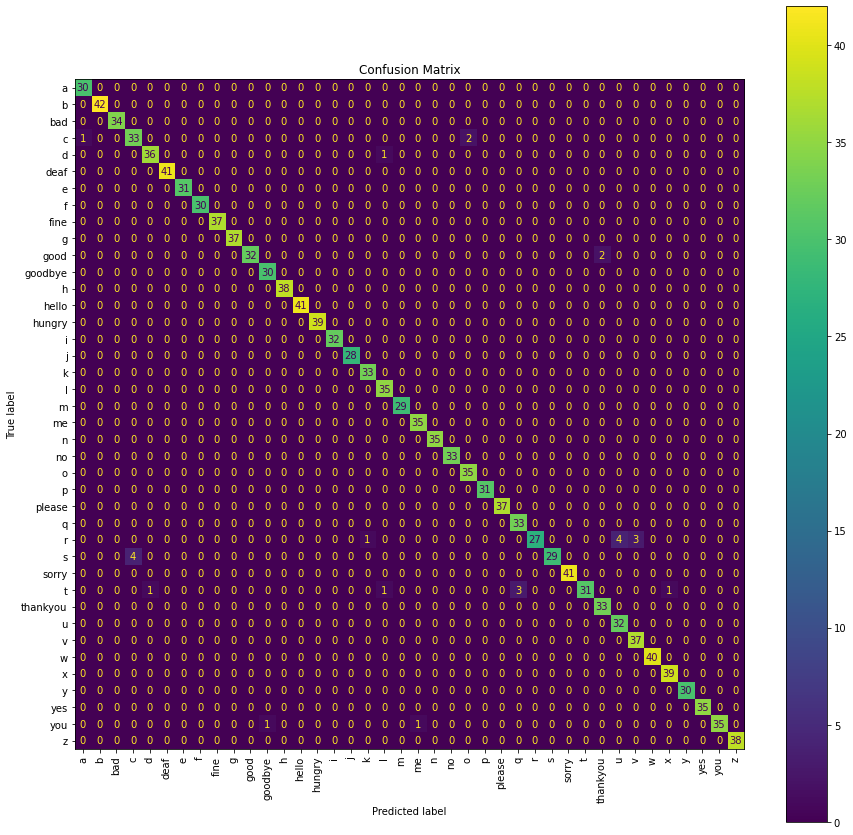

In [ ]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 15))
title = "Confusion Matrix"
ax.set_title(title)
ax.set_facecolor('tab:gray')

# Plot Confusion Matrix
plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_))
# plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=list(label_encoder.classes_),
#                             cmap=plt.cm.Blues,
#                             normalize=None)

plt.xticks(rotation=90)

plt.savefig('confusion_matrix.jpg', format='jpg')
plt.show()

# **Train** Batch Classifiers and Normalizers

### Function

In [ ]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer, Normalizer

dict_classifiers = {
  "Logistic Regression": LogisticRegression(max_iter=1000,solver='saga'),
  "Nearest Neighbors": KNeighborsClassifier(),
  "RBF SVM": SVC(C=10000,gamma=0.1),
  "Linear SVM": SVC(kernel='linear'),
  "Gradient Boosting Classifier": GradientBoostingClassifier(n_estimators=100),
  "Decision Tree": tree.DecisionTreeClassifier(),
  "Random Forest": RandomForestClassifier(n_estimators=100),
  "Neural Net": MLPClassifier(alpha = 1),
  "Naive Bayes": GaussianNB(),
  "AdaBoost": AdaBoostClassifier(),
  "QDA": QuadraticDiscriminantAnalysis(),
  "Gaussian Process": GaussianProcessClassifier()
}

dict_normalizers = {
  'No Normalizer': None,
  'StandardScaler': StandardScaler(),
  'MinMaxScaler': MinMaxScaler(),
  'MaxAbsScaler': MaxAbsScaler(),
  'RobustScaler': RobustScaler(),
  'QuantileTransformer-Normal': QuantileTransformer(output_distribution='normal'),
  'QuantileTransformer-Uniform': QuantileTransformer(output_distribution='uniform'),
  'PowerTransformer-Yeo-Johnson': PowerTransformer(method='yeo-johnson'),
  'Normalizer': Normalizer()
}


def batch_classify(X_train, Y_train, X_test, Y_test, verbose = True):
  """
  This method, takes as input the X, Y matrices of the Train and Test set.
  And fits them on all of the Classifiers specified in the dict_classifier.
  The trained models, and accuracies are saved in a dictionary. The reason to use a dictionary
  is because it is very easy to save the whole dictionary with the pickle module.

  Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train.
  So it is best to train them on a smaller dataset first and
  decide whether you want to comment them out or not based on the test accuracy score.
  """

  dict_models = []
  for classifier_name, classifier in list(dict_classifiers.items()):
    for normalizer_name, normalizer in list(dict_normalizers.items()):
      t_start = time.time()
      pipe = Pipeline([('nomalizer', normalizer), ('clf', classifier)])
      pipe.fit(X_train, Y_train)
      t_end = time.time()

      t_diff = t_end - t_start
      train_score = pipe.score(X_train, Y_train)
      test_score = pipe.score(X_test, Y_test)

      dict_models.append([classifier_name, normalizer_name, train_score,
                          test_score, t_diff])

      if verbose:
        print("trained {c} in {f:.2f} s".format(c=classifier_name + '__' + normalizer_name, f=t_diff))
  return dict_models


def display_dict_models(dict_models, sort_by="Test_Score"):
  df = pd.DataFrame(dict_models, columns=["Classifier", "Normalizer", 
                                          "Train_Score", "Test_Score", 
                                          "Train_Time"])
  
  df = df.sort_values(by=sort_by, ascending=False)
  display(df)
  df.to_csv("/content/drive/MyDrive/Hand-Gesture-Recognition/batch_classifier_result.csv", index=False)


### Code

In [ ]:
# Train-Test Split
# X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state=1234)

dict_models = batch_classify(X_train, y_train, X_test, y_test)
display_dict_models(dict_models)

#**Analysis_1** 

### Test set prediction result for each user

## **Code**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# selected_users = ['001', '002', '003']
selected_users = users

# Iterate over users as single test case
for test_users in selected_users:
  test_users = [test_users]
  train_users = [x for x in selected_users if x not in test_users]

  # Update X_train, y_train
  X_train = pd.DataFrame()
  y_train = np.array([])

  if isinstance(train_users, list):
    for user in train_users:
      X_train = X_train.append(feature_sets[int(user)-1], ignore_index=True)
      y_train = np.append(y_train, label_sets[int(user)-1])
  else:
    raise ValueError("Train set type must be a 'list'.")
  

  # Update X_test, y_test
  X_test = pd.DataFrame()
  y_test = np.array([])

  if isinstance(test_users, list):
    for user in test_users:
      X_test = X_test.append(feature_sets[int(user)-1], ignore_index=True)
      y_test = np.append(y_test, label_sets[int(user)-1])
  else:
    raise ValueError("Test set type must be a 'list'.")

  X_train, y_train = shuffle(X_train, y_train, random_state=43)

  # accuracy = 0
  # num_iter = 5
  # failed_classes = set()
  # for i in range(num_iter):
  #   clf = RandomForestClassifier(n_estimators=100)
  #   clf.fit(X_train,y_train)
  #   y_pred = clf.predict(X_test)
  #   accuracy += accuracy_score(y_test,y_pred)
  #   failed_classes = failed_classes.union(set(y_test.astype(int)) - set(y_pred.astype(int)))
  # accuracy /= num_iter

  # failed_classes = label_encoder.inverse_transform(list(failed_classes))


  accuracy = 0
  num_iter = 10
  failed_classes = set()
  for i in range(num_iter):
    pipe = Pipeline([('nomalizer', StandardScaler()), ('clf', LogisticRegression(max_iter=1000,solver='saga'))])
    # clf = RandomForestClassifier(n_estimators=100)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    accuracy += accuracy_score(y_test,y_pred)
    failed_classes = failed_classes.union(set(y_test.astype(int)) - set(y_pred.astype(int)))
  accuracy /= num_iter

  failed_classes = label_encoder.inverse_transform(list(failed_classes))

  print('|' , end=' ')
  print(*train_users, sep=", ", end=' ')
  print('|' , end=' ')
  print(*test_users, end=' ')
  print('|' , end=' ')
  print("%0.2f" %(accuracy), end=' ')
  print('|' , end=' ')
  print(*failed_classes, sep=", ", end=' ')
  print('|' , end='\n')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

KeyboardInterrupt: ignored

## Result




---

> Single User Test Set [UNFILTERED] [FLEX, GYR, ACC_world]

---


| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002, 003, 004, 005, 006, 007 | 001 | 0.89 | r, t |
| 001, 003, 004, 005, 006, 007 | 002 | 0.89 |  |
| 001, 002, 004, 005, 006, 007 | 003 | 0.86 | t, o |
| 001, 002, 003, 005, 006, 007 | 004 | 0.69 | n, hungry, sorry, t |
| 001, 002, 003, 004, 006, 007 | 005 | 0.78 | l, good, t |
| 001, 002, 003, 004, 005, 007 | 006 | 0.79 | u, c, o |
| 001, 002, 003, 004, 005, 006 | 007 | 0.61 | a, v, x, e, n, s, t |



---


> Single User Test Set [FILTERED] [FLEX, GYR, ACC_world]

---


| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002, 003, 004, 005, 006, 007 | 001 | 0.90 | r, t |
| 001, 003, 004, 005, 006, 007 | 002 | 0.92 | t |
| 001, 002, 004, 005, 006, 007 | 003 | 0.86 | t, o |
| 001, 002, 003, 005, 006, 007 | 004 | 0.70 | x, n, hungry, t |
| 001, 002, 003, 004, 006, 007 | 005 | 0.80 | l, good, s, t |
| 001, 002, 003, 004, 005, 007 | 006 | 0.79 | u, v, c, d, o |
| 001, 002, 003, 004, 005, 006 | 007 | 0.62 | a, e, m, n, s, t, u, v, x, you |


---

> Single User Test Set [FILTERED] [FLEX, GYR, ACC_raw]

---

| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002, 003, 004, 005, 006, 007 | 001 | 0.86 | c, r, t |
| 001, 003, 004, 005, 006, 007 | 002 | 0.89 |  |
| 001, 002, 004, 005, 006, 007 | 003 | 0.87 |  |
| 001, 002, 003, 005, 006, 007 | 004 | 0.72 | x, deaf, hungry, n |
| 001, 002, 003, 004, 006, 007 | 005 | 0.81 | l, t |
| 001, 002, 003, 004, 005, 007 | 006 | 0.84 | v, c, d, o |
| 001, 002, 003, 004, 005, 006 | 007 | 0.64 | a, u, v, x, e, you, m, n, s, t |

---

> Single User Test Set and Variable User Train  [FILTERED] [FLEX, GYR, ACC_body]

---
| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002, 003, 004, 005, 006, 007 | 001 | 0.89 | r, t |
| 001, 003, 004, 005, 006, 007 | 002 | 0.93 | x |
| 001, 002, 004, 005, 006, 007 | 003 | 0.87 | t, o |
| 001, 002, 003, 005, 006, 007 | 004 | 0.69 | x, deaf, n, t, sorry, hungry |
| 001, 002, 003, 004, 006, 007 | 005 | 0.81 | l, good, s, t |
| 001, 002, 003, 004, 005, 007 | 006 | 0.80 | u, c, d, o |
| 001, 002, 003, 004, 005, 006 | 007 | 0.62 | a, e, m, n, s, t, thankyou, v, x, you |

---

> Single User Test Set and Variable User Train  [SCALED] [FILTERED] [FLEX, GYR, ACC_world]

---
| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002, 003, 004, 005, 006, 007 | 001 | 0.91 | r |
| 001, 003, 004, 005, 006, 007 | 002 | 0.92 |  |
| 001, 002, 004, 005, 006, 007 | 003 | 0.86 | t, o |
| 001, 002, 003, 005, 006, 007 | 004 | 0.70 | x, hungry, n, sorry, t |
| 001, 002, 003, 004, 006, 007 | 005 | 0.79 | l, good, s |
| 001, 002, 003, 004, 005, 007 | 006 | 0.78 | u, k, c, d, o |
| 001, 002, 003, 004, 005, 006 | 007 | 0.61 | a, deaf, e, m, me, n, s, t, v, x, you |

---


#**Analysis_2** 

### Test set prediction result for each test user for variable number of train users

## Code

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# selected_users = ['001', '002', '003']
selected_users = users

# Iterate over users as single test case
for test_users in selected_users:
  test_users = [test_users]
  train_users_total = [x for x in selected_users if x not in test_users]
  train_users = []

  for u in train_users_total:
    train_users.append(u)

    # Update X_train, y_train
    X_train = pd.DataFrame()
    y_train = np.array([])

    if isinstance(train_users, list):
      for user in train_users:
        X_train = X_train.append(feature_sets[int(user)-1], ignore_index=True)
        y_train = np.append(y_train, label_sets[int(user)-1])
    else:
      raise ValueError("Train set type must be a 'list'.")
    

    # Update X_test, y_test
    X_test = pd.DataFrame()
    y_test = np.array([])

    if isinstance(test_users, list):
      for user in test_users:
        X_test = X_test.append(feature_sets[int(user)-1], ignore_index=True)
        y_test = np.append(y_test, label_sets[int(user)-1])
    else:
      raise ValueError("Test set type must be a 'list'.")

    X_train, y_train = shuffle(X_train, y_train, random_state=43)
    
    accuracy = 0
    num_iter = 5
    failed_classes = set()
    for i in range(num_iter):
      clf = RandomForestClassifier(n_estimators=100)
      clf.fit(X_train,y_train)
      y_pred = clf.predict(X_test)
      accuracy += accuracy_score(y_test,y_pred)
      failed_classes = failed_classes.union(set(y_test.astype(int)) - set(y_pred.astype(int)))
    accuracy /= num_iter

    failed_classes = label_encoder.inverse_transform(list(failed_classes))  

    print('|' , end=' ')
    print(*train_users, sep=", ", end=' ')
    print('|' , end=' ')
    print(*test_users, end=' ')
    print('|' , end=' ')
    print("%0.2f" %(accuracy), end=' ')
    print('|' , end=' ')
    print(*failed_classes, sep=", ", end=' ')
    print('|' , end='\n')


NameError: ignored

## Result


---

> Single User Test Set and Variable User Train  [UNFILTERED] [FLEX, GYR, ACC_world]

---


| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002 | 001 | 0.57 | a, d, e, f, i, k, l, m, me, n, r, w |
| 002, 003 | 001 | 0.82 | u, x, me, r, s |
| 002, 003, 004 | 001 | 0.86 | u, x, me, r, s |
| 002, 003, 004, 005 | 001 | 0.87 | r, s |
| 002, 003, 004, 005, 006 | 001 | 0.88 | r, s, t |
| 002, 003, 004, 005, 006, 007 | 001 | 0.88 | r |
| 001 | 002 | 0.64 | b, v, x, me, r, i |
| 001, 003 | 002 | 0.85 | x, r |
| 001, 003, 004 | 002 | 0.89 | x |
| 001, 003, 004, 005 | 002 | 0.89 | x |
| 001, 003, 004, 005, 006 | 002 | 0.90 |  |
| 001, 003, 004, 005, 006, 007 | 002 | 0.90 |  |
| 001 | 003 | 0.67 | c, e, you, s |
| 001, 002 | 003 | 0.83 | v, o, p, s, t |
| 001, 002, 004 | 003 | 0.88 | s, o |
| 001, 002, 004, 005 | 003 | 0.85 | t |
| 001, 002, 004, 005, 006 | 003 | 0.85 | t, o |
| 001, 002, 004, 005, 006, 007 | 003 | 0.86 | e, o, t |
| 001 | 004 | 0.46 | c, fine, good, hungry, me, n, q, sorry, t, v, x, yes, you |
| 001, 002 | 004 | 0.57 | x, deaf, you, yes, fine, good, hungry, me, n, t |
| 001, 002, 003 | 004 | 0.64 | x, deaf, fine, good, hungry, n, sorry, t |
| 001, 002, 003, 005 | 004 | 0.67 | n, t, fine, q, hungry |
| 001, 002, 003, 005, 006 | 004 | 0.68 | x, n, hungry, hello, t |
| 001, 002, 003, 005, 006, 007 | 004 | 0.67 | x, n, t, sorry, hungry |
| 001 | 005 | 0.61 | k, l, n, good, t, thankyou |
| 001, 002 | 005 | 0.78 | good |
| 001, 002, 003 | 005 | 0.74 | k, l, good, t |
| 001, 002, 003, 004 | 005 | 0.77 | l, good, t |
| 001, 002, 003, 004, 006 | 005 | 0.81 | l, good, t |
| 001, 002, 003, 004, 006, 007 | 005 | 0.79 | l, t |
| 001 | 006 | 0.52 | c, you, good, me, n, o, q, t, thankyou |
| 001, 002 | 006 | 0.67 | u, v, c, n, o |
| 001, 002, 003 | 006 | 0.70 | u, v, c, k, o |
| 001, 002, 003, 004 | 006 | 0.78 | u, v, c, k, o |
| 001, 002, 003, 004, 005 | 006 | 0.80 | u, c, o |
| 001, 002, 003, 004, 005, 007 | 006 | 0.79 | u, c, o |
| 001 | 007 | 0.46 | a, d, e, g, i, m, me, n, q, r, s, sorry, t, thankyou, u, x, you |
| 001, 002 | 007 | 0.53 | a, d, e, i, k, l, m, me, n, s, t, v, x, you |
| 001, 002, 003 | 007 | 0.57 | a, e, l, m, me, n, q, s, t, v, x, you |
| 001, 002, 003, 004 | 007 | 0.61 | a, x, e, m, n, s, t |
| 001, 002, 003, 004, 005 | 007 | 0.60 | a, e, l, m, me, n, s, t, v, x, you |
| 001, 002, 003, 004, 005, 006 | 007 | 0.62 | a, u, v, x, e, l, n, s, t |



---

> Single User Test Set and Variable User Train  [FILTERED] [FLEX, GYR, ACC_world]

---


| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002 | 001 | 0.59 | a, w, e, k, l, m, me, n |
| 002, 003 | 001 | 0.79 | u, x, d, m, me, r, s |
| 002, 003, 004 | 001 | 0.86 | me, r, s |
| 002, 003, 004, 005 | 001 | 0.89 | r, s |
| 002, 003, 004, 005, 006 | 001 | 0.90 | r, t |
| 002, 003, 004, 005, 006, 007 | 001 | 0.90 | r |
| 001 | 002 | 0.60 | u, b, x, y, i, l, me, n, p, r, t |
| 001, 003 | 002 | 0.85 | p, r |
| 001, 003, 004 | 002 | 0.90 | x, t |
| 001, 003, 004, 005 | 002 | 0.92 | x |
| 001, 003, 004, 005, 006 | 002 | 0.90 |  |
| 001, 003, 004, 005, 006, 007 | 002 | 0.91 |  |
| 001 | 003 | 0.59 | v, c, y, you, hungry, p, q, s |
| 001, 002 | 003 | 0.84 | p, s, t |
| 001, 002, 004 | 003 | 0.87 |  |
| 001, 002, 004, 005 | 003 | 0.84 | p |
| 001, 002, 004, 005, 006 | 003 | 0.85 | p, t |
| 001, 002, 004, 005, 006, 007 | 003 | 0.87 | t, o |
| 001 | 004 | 0.40 | fine, good, hungry, k, me, n, q, sorry, t, u, v, y, yes, you |
| 001, 002 | 004 | 0.59 | deaf, yes, you, fine, good, hello, hungry, me, n, sorry, t |
| 001, 002, 003 | 004 | 0.64 | x, deaf, fine, good, hungry, n, sorry, t |
| 001, 002, 003, 005 | 004 | 0.66 | n, hungry, t |
| 001, 002, 003, 005, 006 | 004 | 0.69 | x, hello, hungry, n, t |
| 001, 002, 003, 005, 006, 007 | 004 | 0.70 | x, n, hungry, t |
| 001 | 005 | 0.58 | v, x, d, y, k, l, n, q, t |
| 001, 002 | 005 | 0.73 | k, v, l, d, good |
| 001, 002, 003 | 005 | 0.73 | v, good, k, l, s, t |
| 001, 002, 003, 004 | 005 | 0.76 | good, l |
| 001, 002, 003, 004, 006 | 005 | 0.79 | l, good, s, t |
| 001, 002, 003, 004, 006, 007 | 005 | 0.79 | l |
| 001 | 006 | 0.47 | c, d, x, you, good, k, me, t, thankyou |
| 001, 002 | 006 | 0.70 | u, v, c, n, o |
| 001, 002, 003 | 006 | 0.72 | u, v, c, k, o, q, t |
| 001, 002, 003, 004 | 006 | 0.79 | u, v, c, k, o, s |
| 001, 002, 003, 004, 005 | 006 | 0.79 | u, c, o |
| 001, 002, 003, 004, 005, 007 | 006 | 0.78 | u, c, o |
| 001 | 007 | 0.43 | a, b, d, e, g, i, m, me, n, q, r, s, t, thankyou, u, x, you |
| 001, 002 | 007 | 0.52 | a, d, e, i, k, l, m, me, n, q, s, t, u, v, x, you |
| 001, 002, 003 | 007 | 0.56 | a, e, l, m, me, n, q, s, t, u, v, x, you |
| 001, 002, 003, 004 | 007 | 0.61 | a, e, m, me, n, q, s, t, thankyou, v, x, you |
| 001, 002, 003, 004, 005 | 007 | 0.59 | a, deaf, e, m, me, n, s, t, v, x, you |
| 001, 002, 003, 004, 005, 006 | 007 | 0.63 | a, u, v, x, e, you, m, n, s, t |


---

> Single User Test Set and Variable User Train  [FILTERED] [FLEX, GYR, ACC_raw]

---
| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002 | 001 | 0.58 | a, w, f, i, m, me, n |
| 002, 003 | 001 | 0.77 | x, d, m, me, r, s, t |
| 002, 003, 004 | 001 | 0.85 | x, me, r, s |
| 002, 003, 004, 005 | 001 | 0.87 | r, n |
| 002, 003, 004, 005, 006 | 001 | 0.88 | r, t |
| 002, 003, 004, 005, 006, 007 | 001 | 0.86 | c, r, t |
| 001 | 002 | 0.55 | x, y, h, i, p, please, r |
| 001, 003 | 002 | 0.86 | x, r |
| 001, 003, 004 | 002 | 0.90 | x, t |
| 001, 003, 004, 005 | 002 | 0.89 | x |
| 001, 003, 004, 005, 006 | 002 | 0.88 | o |
| 001, 003, 004, 005, 006, 007 | 002 | 0.90 |  |
| 001 | 003 | 0.59 | y, d, you, e, hungry, n, p, s |
| 001, 002 | 003 | 0.84 | v, c, s, t |
| 001, 002, 004 | 003 | 0.89 | c, s |
| 001, 002, 004, 005 | 003 | 0.85 | c |
| 001, 002, 004, 005, 006 | 003 | 0.86 | t |
| 001, 002, 004, 005, 006, 007 | 003 | 0.87 |  |
| 001 | 004 | 0.44 | v, c, yes, you, f, hungry, me, n, t |
| 001, 002 | 004 | 0.64 | yes, deaf, hungry, k, me, n, sorry, t |
| 001, 002, 003 | 004 | 0.71 | x, deaf, hungry, n, sorry, t |
| 001, 002, 003, 005 | 004 | 0.73 | c, x, deaf, hungry, n, t |
| 001, 002, 003, 005, 006 | 004 | 0.73 | x, deaf, hungry, n |
| 001, 002, 003, 005, 006, 007 | 004 | 0.72 | x, deaf, hungry, n, sorry, t |
| 001 | 005 | 0.57 | x, y, d, good, k, l, p, t |
| 001, 002 | 005 | 0.79 | l, d, t |
| 001, 002, 003 | 005 | 0.78 | l, s, t |
| 001, 002, 003, 004 | 005 | 0.80 | l, good, s |
| 001, 002, 003, 004, 006 | 005 | 0.82 | l, me, good, t |
| 001, 002, 003, 004, 006, 007 | 005 | 0.80 | l, t |
| 001 | 006 | 0.52 | c, d, x, you, f, k, me, thankyou |
| 001, 002 | 006 | 0.71 | u, v, c, you, n, o |
| 001, 002, 003 | 006 | 0.79 | u, v, c, o |
| 001, 002, 003, 004 | 006 | 0.84 | u, v, c, o, s |
| 001, 002, 003, 004, 005 | 006 | 0.85 | c, o |
| 001, 002, 003, 004, 005, 007 | 006 | 0.84 | v, c, d, o |
| 001 | 007 | 0.41 | a, d, e, h, m, me, n, p, r, s, thankyou, u, x, you |
| 001, 002 | 007 | 0.54 | a, e, hello, i, l, m, me, n, s, t, v, x, you |
| 001, 002, 003 | 007 | 0.60 | a, e, i, l, m, n, s, t, v, x |
| 001, 002, 003, 004 | 007 | 0.63 | a, v, x, e, hello, m, n, s, t |
| 001, 002, 003, 004, 005 | 007 | 0.62 | a, deaf, e, m, me, n, s, t, v, x, you |
| 001, 002, 003, 004, 005, 006 | 007 | 0.62 | a, v, x, e, m, n, s, t |

---

> Single User Test Set and Variable User Train  [FILTERED] [FLEX, GYR, ACC_body]

---
| Train Set | Test Set | Accuracy | Failed Classes |
| :---: |:---:| :---: | :---: |
| 002 | 001 | 0.59 | a, k, w, m, n |
| 002, 003 | 001 | 0.79 | u, x, m, me, r, s |
| 002, 003, 004 | 001 | 0.88 | x, me, r, s |
| 002, 003, 004, 005 | 001 | 0.89 | r |
| 002, 003, 004, 005, 006 | 001 | 0.89 | r, s, t |
| 002, 003, 004, 005, 006, 007 | 001 | 0.89 | r, me, t |
| 001 | 002 | 0.58 | v, b, x, y, i, p, r |
| 001, 003 | 002 | 0.83 | p, r, x |
| 001, 003, 004 | 002 | 0.90 | x, t |
| 001, 003, 004, 005 | 002 | 0.89 |  |
| 001, 003, 004, 005, 006 | 002 | 0.90 |  |
| 001, 003, 004, 005, 006, 007 | 002 | 0.92 | x |
| 001 | 003 | 0.57 | c, you, h, hungry, i, p, q, s |
| 001, 002 | 003 | 0.84 | p, s, t |
| 001, 002, 004 | 003 | 0.88 | s |
| 001, 002, 004, 005 | 003 | 0.85 | c |
| 001, 002, 004, 005, 006 | 003 | 0.85 | t |
| 001, 002, 004, 005, 006, 007 | 003 | 0.88 | t, o |
| 001 | 004 | 0.37 | good, hungry, k, me, n, q, sorry, t, thankyou, v, x, y, yes, you |
| 001, 002 | 004 | 0.60 | deaf, you, hello, hungry, m, me, n, sorry, t |
| 001, 002, 003 | 004 | 0.67 | x, deaf, yes, good, hello, hungry, n, sorry, t |
| 001, 002, 003, 005 | 004 | 0.69 | deaf, hungry, n, t |
| 001, 002, 003, 005, 006 | 004 | 0.70 | x, n, hungry |
| 001, 002, 003, 005, 006, 007 | 004 | 0.69 | x, deaf, hungry, n, sorry, t |
| 001 | 005 | 0.58 | v, x, y, good, l, n, t |
| 001, 002 | 005 | 0.77 | good, l, s |
| 001, 002, 003 | 005 | 0.77 | v, l, good, t |
| 001, 002, 003, 004 | 005 | 0.79 | l, good, t |
| 001, 002, 003, 004, 006 | 005 | 0.83 | l, good, s, t |
| 001, 002, 003, 004, 006, 007 | 005 | 0.81 | l, good, s |
| 001 | 006 | 0.43 | c, d, x, you, g, me, o, q, t, thankyou |
| 001, 002 | 006 | 0.70 | u, v, c, you, o |
| 001, 002, 003 | 006 | 0.75 | u, v, c, k, o, t |
| 001, 002, 003, 004 | 006 | 0.79 | u, v, c, k, o |
| 001, 002, 003, 004, 005 | 006 | 0.81 | u, c, o |
| 001, 002, 003, 004, 005, 007 | 006 | 0.81 | u, c, d, o |
| 001 | 007 | 0.42 | a, d, e, g, m, me, n, q, r, s, t, thankyou, u, x, you |
| 001, 002 | 007 | 0.52 | a, d, e, hello, i, k, l, m, me, n, q, s, v, x, you |
| 001, 002, 003 | 007 | 0.56 | a, e, l, m, me, n, q, s, t, u, v, x, you |
| 001, 002, 003, 004 | 007 | 0.62 | a, e, hello, m, me, n, q, s, t, v, x, you |
| 001, 002, 003, 004, 005 | 007 | 0.60 | a, deaf, e, m, me, n, s, t, v, x, you |
| 001, 002, 003, 004, 005, 006 | 007 | 0.61 | a, e, m, n, s, t, thankyou, u, v, x, you |

---